# Inflow analysis

Try to find correlation between rainfall and water inflow in the the pipe.

In [1]:
import datetime
import calendar
import json
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

# Load project and prepare data

In [6]:
project_folder = '../../datasets/thorium-medium/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
print(json.dumps(project, indent=4))
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow'].fillna(0)
flow = flow.resample('5T').pad()
rainfall = pd.read_csv(project_folder + 'rainfall1.csv', parse_dates=['time'])
rainfall = rainfall.set_index('time')['rainfall'].fillna(0)
rainfall = rainfall.resample('5T').pad()
flow_rain = pd.concat([flow, rainfall], axis=1).dropna()
flow_rain['day'] = flow_rain.index.map(lambda x: x.date())
flow_rain['month'] = flow_rain.index.map(lambda x: x.date().month)
print(flow_rain.head())
print(flow_rain.tail())

{
    "end-date": "2017-10-01",
    "flows": [
        "flow1"
    ],
    "name": "thorium-medium",
    "rainfalls": [
        "rainfall1"
    ],
    "split-date": "2017-01-01",
    "start-date": "2015-06-02"
}
                           flow  rainfall         day  month
time                                                        
2015-06-01 14:15:00  115.559998       0.0  2015-06-01      6
2015-06-01 14:20:00  115.199997       0.0  2015-06-01      6
2015-06-01 14:25:00  112.209999       0.0  2015-06-01      6
2015-06-01 14:30:00  112.860001       0.0  2015-06-01      6
2015-06-01 14:35:00  113.349998       0.0  2015-06-01      6
                           flow  rainfall         day  month
time                                                        
2017-11-10 14:20:00  107.830002       0.0  2017-11-10     11
2017-11-10 14:25:00  107.459999       0.0  2017-11-10     11
2017-11-10 14:30:00  106.919998       0.0  2017-11-10     11
2017-11-10 14:35:00  105.559998       0.0  2017-11-10    

Add column for different rolling windon operation on rainfall data. This will help to find dry weather patterns and also we will use it to try to find correlation betwee nrainfall intensity and eccessive flow.

In [28]:
flow_rain['precipitation_1h'] = flow_rain.rainfall.rolling(12).sum()
flow_rain['precipitation_2h'] = flow_rain.rainfall.rolling(2*12).sum()
flow_rain['precipitation_4h'] = flow_rain.rainfall.rolling(4*12).sum()
flow_rain['precipitation_8h'] = flow_rain.rainfall.rolling(8*12).sum()
flow_rain['precipitation_24h'] = flow_rain.rainfall.rolling(24*12).sum()
flow_rain['precipitation_48h'] = flow_rain.rainfall.rolling(48*12).sum()
flow_rain[pd.Timestamp('2017-05-01'):pd.Timestamp('2017-05-02')].head(10)

,flow,rainfall,day,month,precipitation_1h,precipitation_2h,precipitation_4h,precipitation_8h,precipitation_24h,precipitation_48h
time,,,,,,,,,,
2017-05-01 00:00:00,128.320007,0.000,2017-05-01,5,0.254,2.540,11.938,12.954,14.986,14.986
2017-05-01 00:05:00,126.919998,1.016,2017-05-01,5,1.270,3.048,12.954,13.970,16.002,16.002
2017-05-01 00:10:00,124.800003,0.254,2017-05-01,5,1.524,2.794,13.208,14.224,16.256,16.256
2017-05-01 00:15:00,123.400002,0.000,2017-05-01,5,1.524,2.286,13.208,14.224,16.256,16.256
2017-05-01 00:20:00,121.580002,0.000,2017-05-01,5,1.524,2.032,13.208,14.224,16.256,16.256
2017-05-01 00:25:00,120.430000,0.000,2017-05-01,5,1.524,1.778,13.208,14.224,16.256,16.256
2017-05-01 00:30:00,120.000000,0.254,2017-05-01,5,1.778,2.032,13.462,14.478,16.510,16.510
2017-05-01 00:35:00,118.320000,0.000,2017-05-01,5,1.778,2.032,13.462,14.478,16.510,16.510
2017-05-01 00:40:00,117.730003,0.000,2017-05-01,5,1.778,1.778,13.462,14.478,16.510,16.510


# Dry Weather Pattern

Dry Weather Pattern is daily flow when we know that there was no precipitation at least 8h before this day and during this day

## Mean DWP

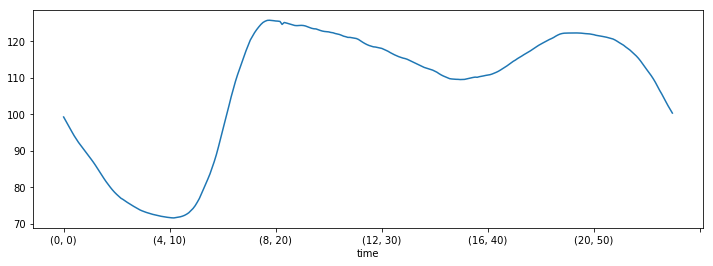

In [14]:
df = flow_rain[flow_rain.precipitation_24h < 0.1].reset_index()
daily_pattern = df.groupby(by=[df.time.map(lambda x : (x.hour, x.minute))]).flow.mean()
daily_pattern.plot()
plt.show()

## How the DWP changes during the year

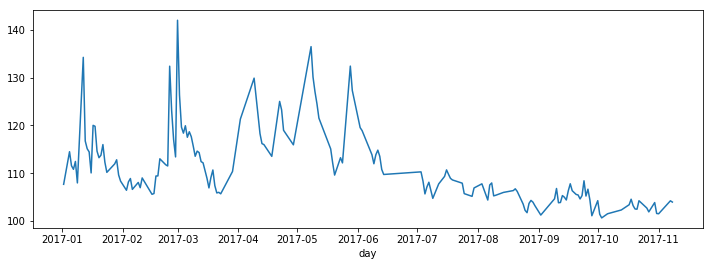

In [30]:
df = flow_rain['2017-01-01':].groupby(by=['day']).mean()
days = df[df.precipitation_24h < 0.1]
days.flow.plot()
plt.show()

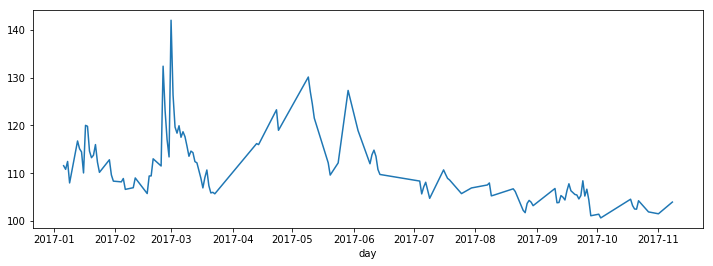

In [31]:
df = flow_rain['2017-01-01':].groupby(by=['day']).mean()
days = df[df.precipitation_48h < 0.1]
days.flow.plot()
plt.show()

## Explore peaks

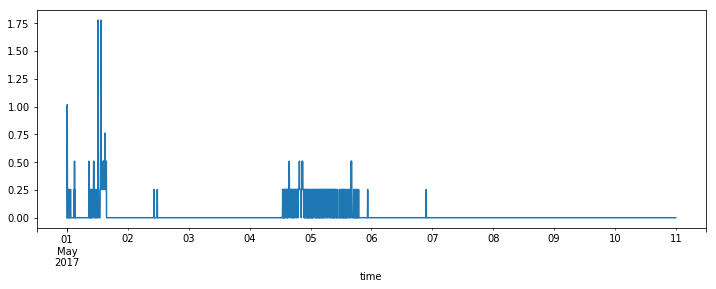

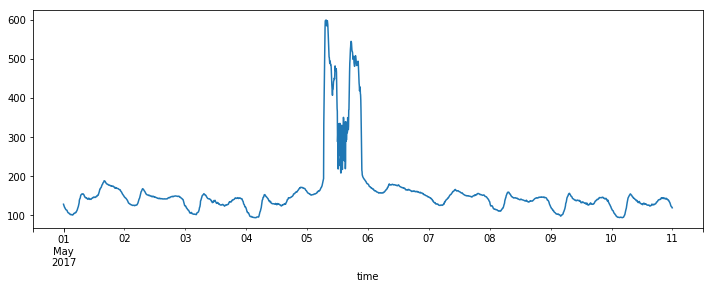

In [33]:
df = flow_rain['2017-05-01':'2017-05-10']
df.rainfall.plot()
plt.show()
df.flow.plot()
plt.show()

## Add inflow data based on daily pattern

In [39]:
def inflow(row):
    pattern_idx = (row.name.hour, row.name.minute)
    pattern_value = daily_pattern[pattern_idx]
    return row.flow - pattern_value


flow_rain['inflow'] = flow_rain.apply(inflow, axis=1)
flow_rain.tail()

,flow,rainfall,precipitation_1h,precipitation_2h,precipitation_4h,precipitation_8h,inflow
time,,,,,,,
2017-11-10 14:20:00,107.830002,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-4.900445
2017-11-10 14:25:00,107.459999,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-5.079138
2017-11-10 14:30:00,106.919998,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-5.460512
2017-11-10 14:35:00,105.559998,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-6.519046
2017-11-10 14:40:00,104.940002,0.0,-9.325873e-15,-3.930190e-14,-3.019807e-14,9.769963e-14,-6.870444


# Check rainfall - inflow correlation

## Check 1 hour precipitation correlation

y = 4.269x + -1.845


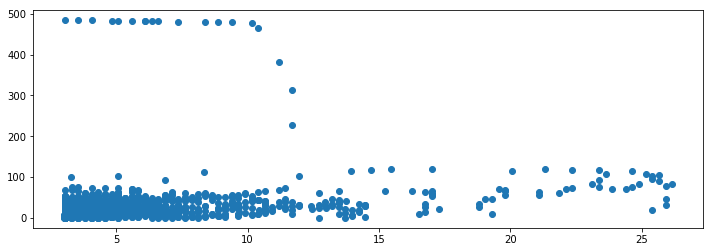

In [75]:
df = flow_rain[(flow_rain.precipitation_1h > 3) & (flow_rain.inflow < 2000) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_1h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_1h, df.inflow)
plt.show()

## Check 2 hours precipitation correlation

y = 3.277x + -8.635


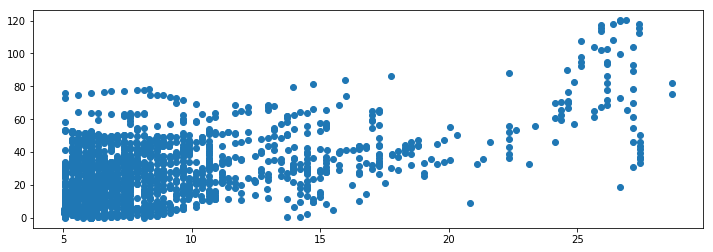

In [68]:
df = flow_rain[(flow_rain.precipitation_2h > 5) & (flow_rain.inflow < 200) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_2h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_2h, df.inflow)
plt.show()

## Check 4 hours precipitation correlation

y = 0.7837x + 4.13


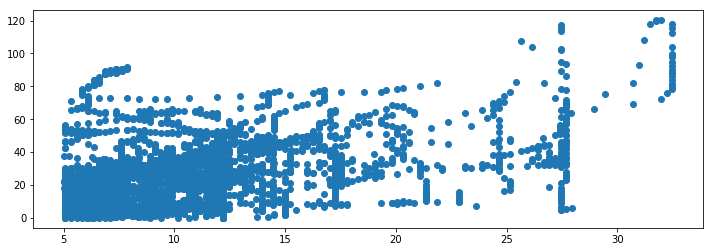

In [57]:
df = flow_rain[(flow_rain.precipitation_4h > 5) & (flow_rain.inflow < 150) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_4h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_4h, df.inflow)
plt.show()

## Check 8 hours precipitation correlation

y = -0.3438x + 21.65


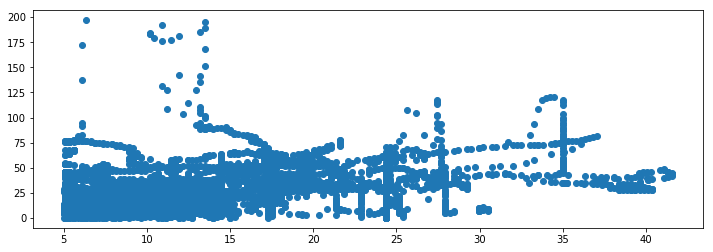

In [58]:
df = flow_rain[(flow_rain.precipitation_8h > 5) & (flow_rain.inflow < 200) & (flow_rain.inflow > 0)]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.precipitation_8h, df.inflow)
print('y = {:.4}x + {:.4}'.format(slope, intercept))
plt.scatter(df.precipitation_8h, df.inflow)
plt.show()

# Analysis of days with very high inflow

In [89]:
set(flow_rain[flow_rain.inflow > 300].index.date)

{datetime.date(2017, 5, 5), datetime.date(2017, 5, 25)}

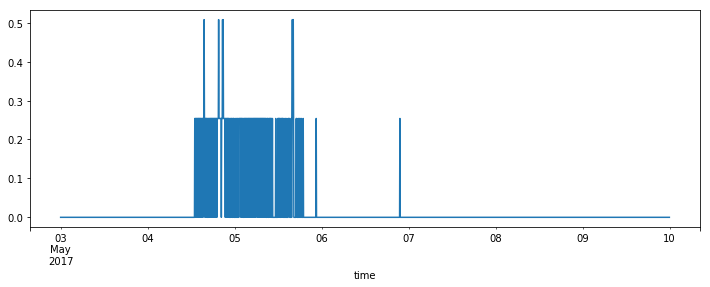

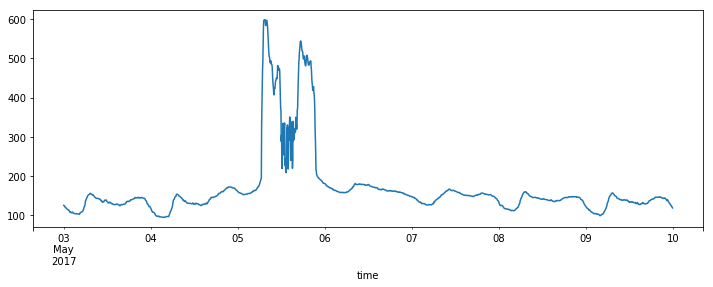

In [95]:
df = flow_rain['2017-05-03': '2017-05-09']
df.rainfall.plot()
plt.show()
df.flow.plot()
plt.show()

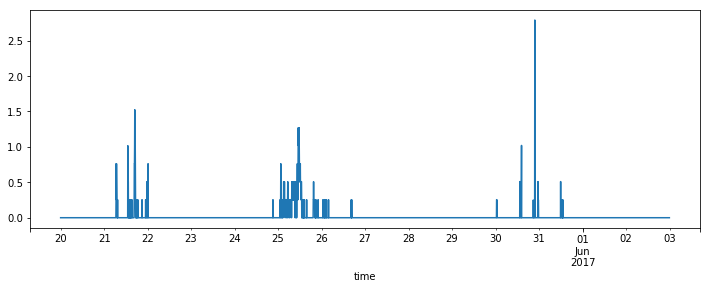

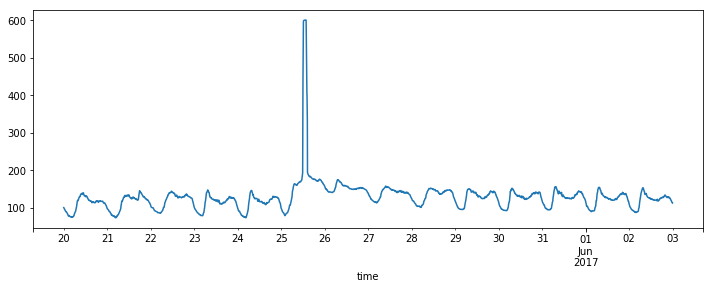

In [97]:
df = flow_rain['2017-05-20': '2017-06-02']
df.rainfall.plot()
plt.show()
df.flow.plot()
plt.show()